# Классификация токсичных комментариев для интернет-магазина

In [23]:
import pandas as pd
import numpy as np 
np.random.seed(seed=42)
import time
import re

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import spacy

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.pipeline import Pipeline

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from IPython.display import display
import pprint
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anshilina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Импортируем и изучим данные. Нам предстоит решить задачу бинарной классификации. Необходимо выделить признаки из текста и определить, является ли он токсичным (негативным) комментарием или нет. 

In [3]:
try:
    df = pd.read_csv('toxic_comments.csv').drop('Unnamed: 0', axis=1)
except:
    df = pd.read_csv('/datasets/toxic_comments.csv').drop('Unnamed: 0', axis=1)
    
display(df.head())

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [5]:
display(df.describe())

,toxic
count,159292.000000
mean,0.101612
std,0.302139
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


Пропусков в данных нет, дубликаты также отсутствуют. 

In [6]:
print('Количество пропусков:', df.isna().sum().sum())

Количество пропусков: 0


In [7]:
print('Количество дубликатов:', df.duplicated().sum())

Количество дубликатов: 0


Визуализируем распределение зависимой переменной. Мы можем наблюдать дисбаланс в классах – в выборке больше комментариев, которые не являются токсичными. При моделировании необходимо учесть дисбаланс. Для этого мы будем использовать специальные параметры моделей. 

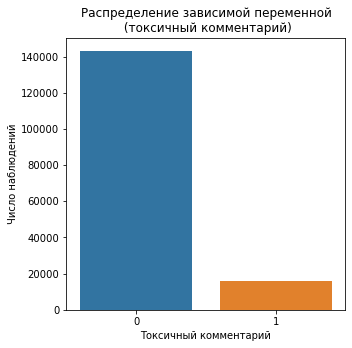

In [8]:
plt.figure(figsize=(5,5))
sns.barplot(data=df, x=df['toxic'].value_counts().index, y=df['toxic'].value_counts().values)
plt.xlabel('Токсичный комментарий')
plt.ylabel('Число наблюдений')
plt.title('Распределение зависимой переменной\n (токсичный комментарий)')
plt.show()

## Подготовка

На первом шаге избавимся от всех ненужных символов кроме букв.

In [9]:
df['text'] = df['text'].apply(lambda row: "".join(re.sub(r'[^a-zA-Z\' ]', ' ', row)))

Далее лемматизируем слова в предложениях. Для этого будем использовать библиотеку `spacy`.

In [10]:
spacy_model = spacy.load('en_core_web_sm')
display(spacy_model.pipe_names)

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

In [11]:
disabled_pipes = ['parser', 'ner']
spacy_model = spacy.load('en_core_web_sm', disable=disabled_pipes)

In [12]:
df['text'] = df['text'].apply(lambda row: " ".join([word.lemma_ for word in spacy_model(row)]))

Избавимся от лишних пропусков и приведем слова к нижнему регистру.

In [13]:
df['text'] = df['text'].apply(lambda row: ' '.join(row.split()).lower())

In [14]:
display(df['text'].head())

0    explanation why the edit make under my usernam...
1    d'aww he match this background colour i be see...
2    hey man i be really not try to edit war it be ...
3    more i can not make any real suggestion on imp...
4    you sir be my hero any chance you remember wha...
Name: text, dtype: object

Далее выгрузим стоп-слова, которые будем исключать при векторизации слов. Для приведения слов к векторам будем использовать `TfidfVectorizer`.

In [15]:
stop_words = set(stopwords.words('english')) 
vectorizer_pipe = Pipeline([("vect", TfidfVectorizer(stop_words=stop_words))])

Разделим выбоку на тренировочную, валидационную и тестовую.

In [17]:
features = df['text']
target = df['toxic']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.1, shuffle=True, random_state=42)

features_train, features_valid, target_train, target_valid = train_test_split(
    features_train, target_train, test_size=0.1, shuffle=True, stratify=target_train, random_state=42)

In [18]:
target_test.value_counts()

0    14314
1     1616
Name: toxic, dtype: int64

## Обучение

Обучим модели логистической регрессии, случайного леса, CatBoost, LightGBM, XGBoost. Модель дерева решений рассмотрим в качестве базовой – будем сравнивать с ней значения других классификаторов. Подберем вероятностный порог, чтобы получить низкий уровень false positive ответов и высокий уровень true positive ответов.

### Дерево решений

Используем параметр `class_weight` для борьбы с дисбалансом. 

In [19]:
tree_model = Pipeline([
    ('vectorizer', vectorizer_pipe),
    ('tree', DecisionTreeClassifier(random_state=42, class_weight='balanced'))
])
tree_params = {'tree__max_depth' : range(2, 13, 2)}
tree_model = GridSearchCV(tree_model, param_grid=tree_params, cv=5, scoring='f1', n_jobs=-1)

In [20]:
tree_start = time.time()
tree_model.fit(features_train, target_train)
tree_search_time = time.time() - tree_start

In [21]:
print('Результаты подбора параметров.\n')
print(f'Время подбора параметров: {round(tree_search_time/60, 2)} мин')
print(f'Время обучения модели: {round(tree_model.cv_results_["mean_fit_time"][tree_model.best_index_], 5)} сек')
print(f'Время предсказания модели: {round(tree_model.cv_results_["mean_score_time"][tree_model.best_index_], 5)} сек')
print(f'Лучшие значения параметров: {tree_model.best_params_}')
print(f'F1 на кросс-валидации:', tree_model.best_score_)

Результаты подбора параметров.

Время подбора параметров: 1.68 мин
Время обучения модели: 20.1537 сек
Время предсказания модели: 1.67813 сек
Лучшие значения параметров: {'tree__max_depth': 12}
F1 на кросс-валидации: 0.5894383381238686


In [25]:
tree_model = tree_model.best_estimator_
preds = tree_model.predict_proba(features_train)[:,1]

precisions, recalls, thresholds = precision_recall_curve(target_train, preds)
fscores = (2 * precisions * recalls) / (precisions + recalls)
optimal_idx = np.argmax(fscores)
optimal_threshold_tree = thresholds[optimal_idx]

In [26]:
tree_predictions = [1 if prob[1] > optimal_threshold_tree else 0 for prob in tree_model.predict_proba(features_valid)]
print(f'F1 на валидации:', f1_score(target_valid,  tree_predictions))

F1 на валидации: 0.591715976331361


### Случайный лес

Обучим модель случайного леса, подберем параметры и оценим модель на валидационной выборке.

In [27]:
forest_model = Pipeline([
    ('vectorizer', vectorizer_pipe),
    ('forest', RandomForestClassifier(random_state=42, class_weight='balanced'))
])
forest_params = {
    'forest__max_depth' : range(2,13,2),
    'forest__n_estimators': range(10,90,10),
}
forest_model = GridSearchCV(forest_model, param_grid=forest_params, cv=3, scoring='f1', n_jobs=-1)

In [28]:
forest_start = time.time()
forest_model.fit(features_train, target_train)
forest_search_time = time.time() - forest_start

In [29]:
print('Результаты подбора параметров.\n')
print(f'Время подбора параметров: {round(forest_search_time/60, 2)} мин')
print(f'Время обучения модели: {round(forest_model.cv_results_["mean_fit_time"][forest_model.best_index_], 5)} сек')
print(f'Время предсказания модели: {round(forest_model.cv_results_["mean_score_time"][forest_model.best_index_], 5)} сек')
print(f'Лучшие значения параметров:{forest_model.best_params_}')
print(f'F1 на кросс-валидации:', forest_model.best_score_)

Результаты подбора параметров.

Время подбора параметров: 5.24 мин
Время обучения модели: 12.45469 сек
Время предсказания модели: 2.98446 сек
Лучшие значения параметров:{'forest__max_depth': 12, 'forest__n_estimators': 80}
F1 на кросс-валидации: 0.3652188181943883


Качество случайного леса намного ниже, чем у случайного дерева, если не подобрать порог.

In [30]:
forest_model = forest_model.best_estimator_
preds = forest_model.predict_proba(features_train)[:,1]

precisions, recalls, thresholds = precision_recall_curve(target_train, preds)
fscores = (2 * precisions * recalls) / (precisions + recalls)
optimal_idx = np.argmax(fscores)
optimal_threshold_forest = thresholds[optimal_idx]

In [31]:
forest_predictions = [1 if prob[1] > optimal_threshold_forest else 0 for prob in forest_model.predict_proba(features_valid)]
print(f'F1 на валидации:', f1_score(target_valid,  forest_predictions))

F1 на валидации: 0.6547934823796893


### Логистическая регрессия

Теперь рассмотрим линейный классификатор – логистическую регрессию.

In [32]:
log_reg = Pipeline([
    ('vectorizer', vectorizer_pipe),
    ('log', LogisticRegression(class_weight='balanced', solver='liblinear'))
])
log_params = {
    'log__penalty':['l1', 'l2'],
    'log__C':range(5,20,5),
}
log_reg = GridSearchCV(log_reg, param_grid=log_params, cv=3, scoring='f1', n_jobs=-1)

In [33]:
log_start = time.time()
log_reg.fit(features_train, target_train)
log_search_time = time.time() - log_start

In [34]:
print('Результаты подбора параметров.\n')
print(f'Время подбора параметров: {round(log_search_time, 2)} сек')
print(f'Время обучения модели: {round(log_reg.cv_results_["mean_fit_time"][log_reg.best_index_], 5)} сек')
print(f'Время предсказания модели: {round(log_reg.cv_results_["mean_score_time"][log_reg.best_index_], 5)} сек')
print(f'Лучшие значения параметров: {log_reg.best_params_}')
print(f'F1 на кросс-валидации:', log_reg.best_score_)

Результаты подбора параметров.

Время подбора параметров: 63.23 сек
Время обучения модели: 12.44541 сек
Время предсказания модели: 5.47408 сек
Лучшие значения параметров: {'log__C': 10, 'log__penalty': 'l2'}
F1 на кросс-валидации: 0.7633101740809153


In [35]:
log_reg = log_reg.best_estimator_
preds = log_reg.predict_proba(features_train)[:,1]

precisions, recalls, thresholds = precision_recall_curve(target_train, preds)
fscores = (2 * precisions * recalls) / (precisions + recalls)
optimal_idx = np.argmax(fscores)
optimal_threshold_log = thresholds[optimal_idx]

In [36]:
log_predictions = [1 if prob[1] > optimal_threshold_log else 0 for prob in log_reg.predict_proba(features_valid)]
print(f'F1 на валидации:', f1_score(target_valid,  log_predictions))

F1 на валидации: 0.7903168387326451


Далее используем модели градиентного бустинга. Для начала вычислим веса для каждого класса, что позволит решить проблему дисбаланса в моделях Cat Boost и LightGBM.

In [37]:
classes = np.unique(target_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=target_train)
class_weights = dict(zip(classes, weights))

### Cat Boost Classifier

In [66]:
cat_model = Pipeline([
    ('vectorizer', vectorizer_pipe),
    ('cat', CatBoostClassifier(class_weights=class_weights, random_seed=42, loss_function='Logloss', silent=True))
])

In [67]:
cat_start = time.time()
cat_model.fit(features_train, target_train)
cat_fit_time = time.time() - cat_start

In [68]:
cat_start = time.time()
cat_model.predict(features_valid)
cat_pred_time = time.time() - cat_start

In [69]:
print('Результаты обучения.\n')
print(f'Время обучения модели: {round(cat_fit_time/60, 5)} мин')
print(f'Время предсказания модели: {round(cat_pred_time, 5)} сек')
print('F1 на валидационной выборке:', f1_score(target_valid, cat_model.predict(features_valid)))

Результаты обучения.

Время обучения модели: 11.5736 мин
Время предсказания модели: 0.97235 сек
F1 на валидационной выборке: 0.7552795031055901


In [42]:
preds = cat_model.predict_proba(features_train)[:,1]

precisions, recalls, thresholds = precision_recall_curve(target_train, preds)
fscores = (2 * precisions * recalls) / (precisions + recalls)
optimal_idx = np.argmax(fscores)
optimal_threshold_cat = thresholds[optimal_idx]

In [47]:
cat_model['cat'].set_probability_threshold(optimal_threshold_cat)

In [48]:
cat_predictions = [1 if prob[1] > optimal_threshold_cat else 0 for prob in cat_model.predict_proba(features_valid)]
print(f'F1 на валидации:', f1_score(target_valid,  cat_predictions))

F1 на валидации: 0.7777777777777778


Качество достаточно высокое.

### LGBM Classifier

In [49]:
lgbm_model = Pipeline([
    ('vectorizer', vectorizer_pipe),
    ('lgbm', LGBMClassifier(class_weight=class_weights, random_state=42, n_jobs=-1))
])
lgbm_params = {
    'lgbm__learning_rate': [0.03, 0.1],
    'lgbm__n_estimators': range(80, 100, 5),
}
lgbm_model = GridSearchCV(lgbm_model, param_grid=lgbm_params, cv=3, scoring='f1', n_jobs=-1)

In [50]:
lgbm_start = time.time()
lgbm_model.fit(features_train, target_train)
lgbm_search_time = time.time() - lgbm_start

In [51]:
print('Результаты подбора параметров.\n')
print(f'Время подбора параметров: {round(lgbm_search_time/60, 2)} мин')
print(f'Время обучения модели: {round(lgbm_model.cv_results_["mean_fit_time"][lgbm_model.best_index_]/60, 5)} мин')
print(f'Время предсказания модели: {round(lgbm_model.cv_results_["mean_score_time"][lgbm_model.best_index_], 5)} сек')
print(f'Лучшие значения параметров: {lgbm_model.best_params_}')
print(f'F1 на кросс-валидации:', lgbm_model.best_score_)

Результаты подбора параметров.

Время подбора параметров: 4.59 мин
Время обучения модели: 1.21423 мин
Время предсказания модели: 7.20481 сек
Лучшие значения параметров: {'lgbm__learning_rate': 0.1, 'lgbm__n_estimators': 95}
F1 на кросс-валидации: 0.7357299436257833


In [52]:
lgbm_model = lgbm_model.best_estimator_
preds = lgbm_model.predict_proba(features_train)[:,1]

precisions, recalls, thresholds = precision_recall_curve(target_train, preds)
fscores = (2 * precisions * recalls) / (precisions + recalls)
optimal_idx = np.argmax(fscores)
optimal_threshold_lgbm = thresholds[optimal_idx]

In [53]:
lgbm_predictions = [1 if prob[1] > optimal_threshold_lgbm else 0 for prob in lgbm_model.predict_proba(features_valid)]
print(f'F1 на валидации:', f1_score(target_valid,  lgbm_predictions))

F1 на валидации: 0.7679597701149425


Качество модели на валидационной выборке достаточно высокое, но ниже чем на Cat Boost. Но скорость обучения выше, чем у Cat Boost.

### XGB Classifier

In [54]:
xgb_class_weight = float(np.sum(target_train == 0) / np.sum(target_train == 1))

In [55]:
xgb_model = Pipeline([
    ('vectorizer', vectorizer_pipe),
    ('xgb', XGBClassifier(random_state=42, n_jobs=-1, scale_pos_weight=xgb_class_weight))
])
xgb_params = {
    'xgb__max_depth': range(6,10,2),
    'xgb__n_estimators': range(50,90,10),
}
xgb_model = GridSearchCV(xgb_model, param_grid=xgb_params, cv=3, scoring='f1', n_jobs=-1)

In [56]:
xgb_start = time.time()
xgb_model.fit(features_train, target_train)
xgb_search_time = time.time() - xgb_start

In [57]:
print('Результаты подбора параметров.\n')
print(f'Время подбора параметров: {round(xgb_search_time/60, 2)} мин')
print(f'Время обучения модели: {round(xgb_model.cv_results_["mean_fit_time"][xgb_model.best_index_]/60, 5)} мин')
print(f'Время предсказания модели: {round(xgb_model.cv_results_["mean_score_time"][xgb_model.best_index_], 5)} сек')
print(f'Лучшие значения параметров: {xgb_model.best_params_}')
print(f'F1 на кросс-валидации:', xgb_model.best_score_)

Результаты подбора параметров.

Время подбора параметров: 8.32 мин
Время обучения модели: 2.82763 мин
Время предсказания модели: 2.6321 сек
Лучшие значения параметров: {'xgb__max_depth': 8, 'xgb__n_estimators': 80}
F1 на кросс-валидации: 0.7426201577028179


In [58]:
xgb_model = xgb_model.best_estimator_
preds = xgb_model.predict_proba(features_train)[:,1]

precisions, recalls, thresholds = precision_recall_curve(target_train, preds)
fscores = (2 * precisions * recalls) / (precisions + recalls)
optimal_idx = np.argmax(fscores)
optimal_threshold_xgb = thresholds[optimal_idx]

In [59]:
xgb_predictions = [1 if prob[1] > optimal_threshold_xgb else 0 for prob in xgb_model.predict_proba(features_valid)]
print(f'F1 на валидации:', f1_score(target_valid,  xgb_predictions))

F1 на валидации: 0.7640369580668088


Качество модели на валидационной выборке недостаточно высокое, после подбора порога – ниже чем на Cat Boost и LightGBM. При этом XGBoost обучается медленее, чем LightGBM.

**Вывод:** Лучший показатель на валидационной выборке у линейного классификатора. Результаты сравнения моделей представлены в таблице. Оценка F1 на валидации для CatBoost и Логистической регрессии близки – 0.78 и 0.79 соответсвенно. Но логистическая регрессия обучается и делает предсказания быстрее. Поэтому будем использовать модель логистической регрессии для классификации коментариев. 

|Модель|Время обучения|Время предсказания| F1 score на валидации|
|:---|:---|:---|:---|
|Логистическая регрессия|12.45 сек|5.47 сек|0.79|
|CatBoost|10.93 мин|0.96 сек| 0.78|
|LightGBM|1.21 мин|7.20 сек|0.77|
|XGBoost|2.83 мин|2.63 сек| 0.76|
|Случайный лес|12.45 сек|2.98 сек|0.65|
|Дерево решений|20.15 сек|1.68 сек|0.59|

## Тест

In [60]:
print('Результаты предсказания логистической регрессии на тестовой выборке.\n')
log_test_pred = [1 if prob[1] > optimal_threshold_log else 0 for prob in log_reg.predict_proba(features_test)]
print('F1 на тестовой выборке:', f1_score(target_test, log_test_pred))

Результаты предсказания логистической регрессии на тестовой выборке.

F1 на тестовой выборке: 0.7919463087248322


In [61]:
proba_test = log_reg.predict_proba(features_test)[:,1]
print('AUC-ROC:', roc_auc_score(target_test, proba_test))

AUC-ROC: 0.9709045150008924


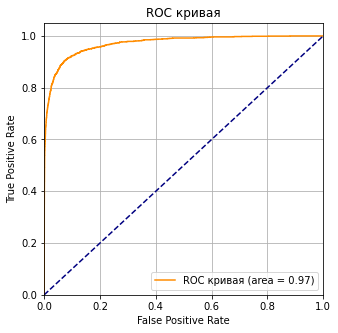

In [64]:
fpr, tpr, treshold = roc_curve(target_test, proba_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC кривая')
plt.legend(loc="lower right")
plt.grid()
plt.show()

## Выводы

В проекте была решена задача классификации комментариев на токсичные и не токсичные. Целевая метрика была достигнута – качество на тестовой выборке (F1 score)  0.79. Для достижения целевой метрики мы подбирали оптимальное пороговое значение. 

На первом этапе исследования мы получили признаки из текста. Текст был очищен от лишних символов, лемматизирован, а затем – векторизован с использованием формулы TF-IDF, которая позволяет оценить уникальность токена (слова) в тексте относительно всего корпуса. В процессе подготовки данных мы также обнаружили дисбаланс в классах – комментариев, которые не являются токсичными, намного больше чем тех, что являются токсичными. Эту проблему мы постарались учесть, задав соответсвующие параметры моделей.

Далее мы обучили шесть моделей – Дерево решений, Случайный лес, Логистическую регрессию, а также модели градиентного бустинга CatBoost, LightGBM и XGBoost. Получив результаты обучения, мы сравнили метрики качества, а также скорость обучения и предсказания моделей. В результате в качестве итоговой модели, которую предлагается использовать для поиска токсичных комментариев, была выбрана Логистическая регрессия.